# BIGDFT V NWCHEM

F:\PhD\backup\PhD_final\benchmark

In [1]:
from BigDFT import Calculators as calc
# study = calc.SystemCalculator()
from BigDFT import Logfiles as lf
import string

In [2]:
import numpy as np
import constants as const
# from func_tool import lin_get_data
import subprocess
import os, os.path
import glob
import matplotlib.pyplot as plt
import pandas as pd #for table
import itertools

In [3]:
marker = itertools.cycle((',', '+', '.', 'o', '*', '1', '2', '3', 'x'))
colour = itertools.cycle(('b','g','r'))
line_markers = itertools.cycle(('-','_'))

for i in range(5):
    print line_markers.next()

-
_
-
_
-


In [4]:
Ha2eV = 27.211386245988

In [5]:
og_path = os.getcwd()

In [6]:
codes = ['BigDFT', 'NWChem']
xcs = ['PBE']
basis = ['VDZ','VTZ','VQZ','cubic']
code_to_bas = {'BigDFT':{'cubic'}, 'NWChem': ['VDZ','VTZ','VQZ']}
HL_order = ['HOMO-1', 'HOMO', 'LUMO', 'LUMO+1']

## Molecules

In [7]:
molecules = ['2CzPN', 'CBP','PhCz']
states = ['s0','s1','t1']

In [8]:
def natoms(log_file):
    log = lf.Logfile(log_file)
    n_atoms = log.nat
    return n_atoms

# MWChem

In [9]:
# extract the final total energy from a nwchem output file
def get_e_from_nwchem(filename):
    COMMAND = "grep 'Total DFT' "+filename+" | awk 'END{print($5)}'"
    #COMMAND = "echo $1"  
    e = subprocess.check_output([COMMAND, "sh", filename], shell=True)
    return e
# extract CPU time from nwchem outputfile
def get_cput_from_nwchem(filename):
    #only awk didn't work for some reason
    COMMAND = "grep 'Total time' "+filename+" | awk '/Total time/ {m=$4} END{gsub(/s/,\"\",m);printf(m)}'"
    #backslash \" is need for python to understand the quotation "
    cput = subprocess.check_output([COMMAND,"sh",filename], shell=True)
    return cput
def get_dipole_from_nwchem(filename):
    #only awk didn't work for some reason
    COMMAND = "grep 'Total dipole' "+filename+" | awk 'NR==1{printf($3)}'"
    #backslash \" is need for python to understand the quotation "
    cput = subprocess.check_output([COMMAND,"sh",filename], shell=True)
    return cput
def get_forces_from_nwchem(filename):
    COMMAND = "grep -A 6 'GRADIENT' "+filename+" | awk '/DFT ENERGY GRADIENTS/{flag=1;next}/timer:/{flag=0}flag'"
    forces = subprocess.check_output([COMMAND,"sh",filename], shell=True)
    return forces
def get_evals_from_nwchem(filename):
    COMMAND = "grep -A 9 'Final alpha' "+filename+" | tail -n4 | awk '{printf($2\" \"$4\" \"$6\" \"$8)}'"
    evals = subprocess.check_output([COMMAND,"sh",filename], shell=True)
    return evals

In [10]:
data = {}
data['NWChem'] = {}

os.chdir(og_path+'/NWChem')
print os.getcwd()

for molecule in molecules:
    data['NWChem'][molecule] = {}
    
    
    for bas in code_to_bas['NWChem']:
        data['NWChem'][molecule][bas] = {}
        
        #     #placeholder, for table later, for easier ordering
        for HL in HL_order:
            data['NWChem'][molecule][HL] = float('nan')
        
        for state in states:
            data['NWChem'][molecule][bas][state] = {}
            
            f_name = molecule+'_PBE_s0xyz_'+state+'_'+bas+'.out'
            
            data['NWChem'][molecule][bas]['total_energy'] = {}
            data['NWChem'][molecule][bas]['CPU_time'] = {}
            
            # if calculation is finished
            if len(get_e_from_nwchem(f_name)) != 1:

                data['NWChem'][molecule][bas][state]['total_energy'] = Ha2eV * float(get_e_from_nwchem(f_name))
                data['NWChem'][molecule][bas][state]['CPU_time'] = float(get_cput_from_nwchem(f_name))
                
                # HOMO LUMO #
                if state == 's0':
                    file = open(f_name).readlines()

                    occups = []

                    for line in file:
                        if 'Vector' in line:

                            occups.append(line)

                    for i in range(0,len(occups)):
                        occ = int(occups[i][18])
#                         eigval = float(occups[i][34:].replace('D','E')) * Ha2eV

                        if occ == 0:
                            homo_m_1 = float(occups[i-2][34:47].replace('D','E')) * Ha2eV
                            homo = float(occups[i-1][34:47].replace('D','E')) * Ha2eV
                            lumo = float(occups[i][34:47].replace('D','E')) * Ha2eV
                            lumo_p_1 = float(occups[i+1][34:47].replace('D','E')) * Ha2eV

                            data['NWChem'][molecule][bas]['HOMO-1'] = homo_m_1
                            data['NWChem'][molecule][bas]['HOMO'] = homo
                            data['NWChem'][molecule][bas]['LUMO'] = lumo
                            data['NWChem'][molecule][bas]['LUMO+1'] = lumo_p_1

                            break

            else:
                data['NWChem'][molecule][bas][state]['total_energy'] = 0
                data['NWChem'][molecule][bas][state]['CPU_time'] = 0
os.chdir(og_path)
print os.getcwd()

/workspace/kt4218/PhD_final/benchmark/NWChem
/workspace/kt4218/PhD_final/benchmark


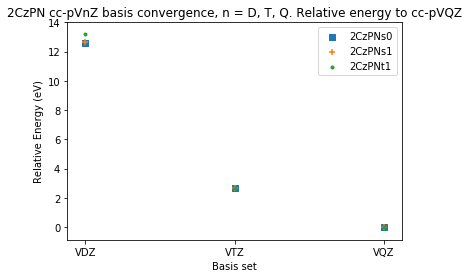

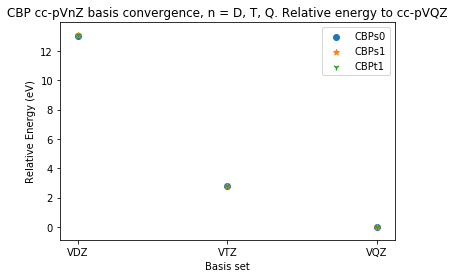

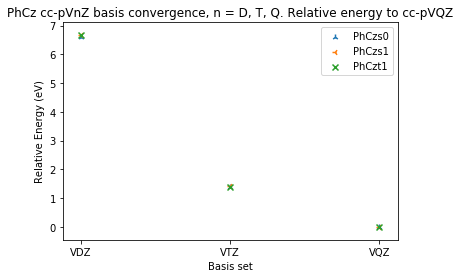

In [11]:
for molecule in molecules:
    for state in states:
        rel_es = []
        
        for bas in code_to_bas['NWChem']:
            max_bas = code_to_bas['NWChem'][-1]
            
            rel_e = data['NWChem'][molecule][bas][state]['total_energy'] - data['NWChem'][molecule][max_bas][state]['total_energy']
            
            rel_es.append(rel_e)
        
        plt.title(molecule+" cc-pVnZ basis convergence, n = D, T, Q. Relative energy to cc-pVQZ")
        plt.scatter([1,2,3], rel_es, label = molecule+state, marker = marker.next())
        
    plt.xticks((1,2,3), ('VDZ', 'VTZ', 'VQZ'))  
    
    plt.legend()
    plt.xlabel('Basis set')
    plt.ylabel('Relative Energy (eV)')
        
    plt.show()

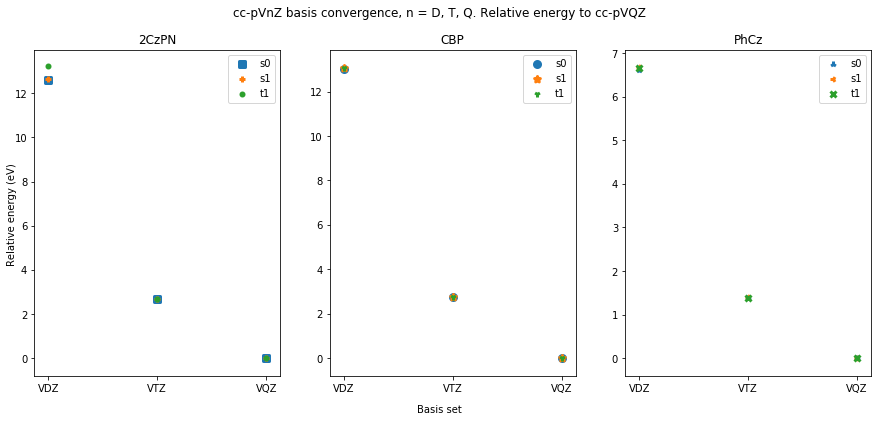

In [12]:
fig, axs = plt.subplots(1,3, figsize=(15,6))

i=0

for molecule in molecules:
    for state in states:
        rel_es = []
        
        for bas in code_to_bas['NWChem']:
            max_bas = code_to_bas['NWChem'][-1]
            
            rel_e = data['NWChem'][molecule][bas][state]['total_energy'] - data['NWChem'][molecule][max_bas][state]['total_energy']
            
            rel_es.append(rel_e)
        
        axs[i].set_title(molecule)
        axs[i].scatter([1,2,3], rel_es, label = state, marker = marker.next(),linewidth=3)
        axs[i].legend()
        axs[i].set_xticks([1, 2, 3])
        axs[i].set_xticklabels(['VDZ', 'VTZ', 'VQZ']) 

    i = 1 + i
        
fig.suptitle("cc-pVnZ basis convergence, n = D, T, Q. Relative energy to cc-pVQZ")    

#set common labels
fig.text(0.1, 0.5, "Relative energy (eV)", va='center', rotation='vertical')
fig.text(0.5, 0.04, "Basis set", ha = "center")

plt.show()

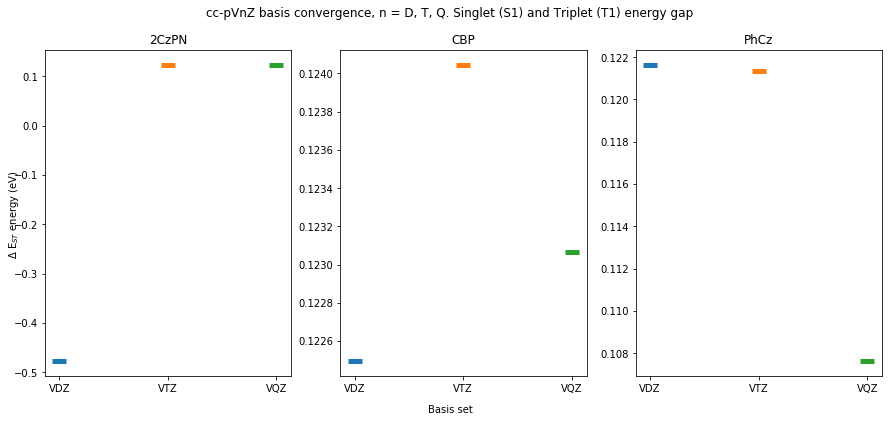

In [13]:
fig, axs = plt.subplots(1,3, figsize=(15,6))

i=0

for molecule in molecules:
    dests = []

    j = 0
        
    for bas in code_to_bas['NWChem']:


        s1 = data['NWChem'][molecule][bas]['s1']['total_energy'] - data['NWChem'][molecule][bas]['s0']['total_energy']
        t1 = data['NWChem'][molecule][bas]['t1']['total_energy'] - data['NWChem'][molecule][bas]['s0']['total_energy']

        dest = s1 - t1

        axs[i].scatter(j, dest, label = state, marker = '_', s = 200, linewidth=5)

        j = j + 1



    axs[i].set_title(molecule)
#     axs[i].legend()
    axs[i].set_xticks([0, 1, 2])
    axs[i].set_xticklabels(['VDZ', 'VTZ', 'VQZ']) 


    i = 1 + i
        
fig.suptitle("cc-pVnZ basis convergence, n = D, T, Q. Singlet (S1) and Triplet (T1) energy gap")    

#set common labels
fig.text(0.09, 0.5, "$\Delta$ E$_{ST}$ energy (eV)", va='center', rotation='vertical')
fig.text(0.5, 0.04, "Basis set", ha = "center")

plt.show()

/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


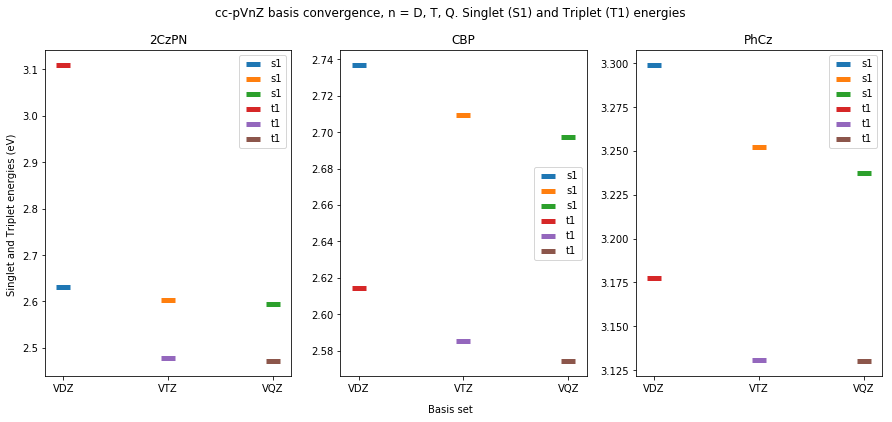

In [14]:
fig, axs = plt.subplots(1,3, figsize=(15,6))

i=0

for molecule in molecules:
    
    for state in states:
        dests = []

        j = 0
        
        for bas in code_to_bas['NWChem']:
        

            if state != 's0':
                dest = data['NWChem'][molecule][bas][state]['total_energy'] - data['NWChem'][molecule][bas]['s0']['total_energy']

#                 dests.append(dest)
#                 print dest, molecule, state, bas
                
                axs[i].scatter(j, dest, label = state, marker = '_', s = 200, linewidth=5)
                
                j = j + 1
                
#         print dests, molecule, state
        
            axs[i].set_title(molecule)
#             axs[i].scatter(j, dests, label = state, marker = marker.next())
            axs[i].legend()
            axs[i].set_xticks([0, 1, 2])
            axs[i].set_xticklabels(['VDZ', 'VTZ', 'VQZ']) 


    i = 1 + i
        
fig.suptitle("cc-pVnZ basis convergence, n = D, T, Q. Singlet (S1) and Triplet (T1) energies")    

#set common labels
fig.text(0.09, 0.5, "Singlet and Triplet energies (eV)", va='center', rotation='vertical')
fig.text(0.5, 0.04, "Basis set", ha = "center")

plt.show()

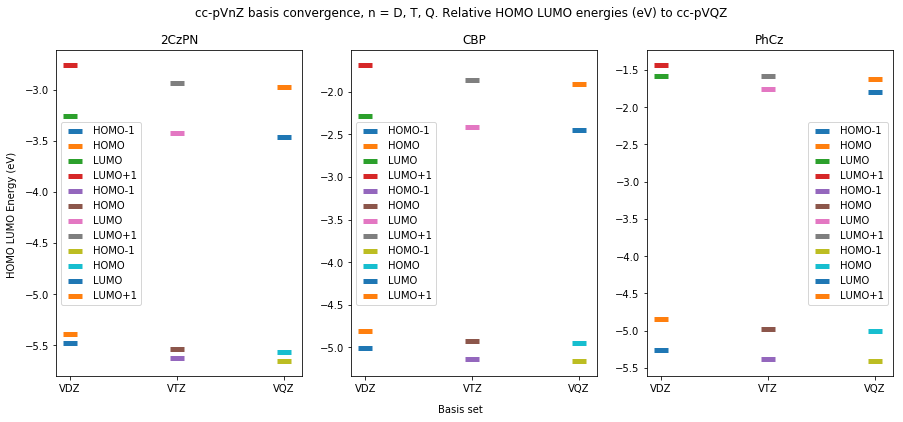

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15,6))

i=0

for molecule in molecules:
    j = 0
    for bas in code_to_bas['NWChem']:
        for HL in HL_order:
#             print data['NWChem'][molecule][bas][HL], molecule, bas, HL
            HL_e = data['NWChem'][molecule][bas][HL]
#             print HL_e, molecule, bas, HL
            axs[i].scatter(j, HL_e, label = HL, marker = '_', s = 200, linewidth=5)
            
            axs[i].legend()
        j = j + 1
    
    axs[i].set_title(molecule)
    axs[i].set_xticks([0, 1, 2])
    axs[i].set_xticklabels(['VDZ', 'VTZ', 'VQZ']) 
    
    i = 1 + i
    
    
fig.suptitle("cc-pVnZ basis convergence, n = D, T, Q. Relative HOMO LUMO energies (eV) to cc-pVQZ")    

#set common labels
fig.text(0.08, 0.5, "HOMO LUMO Energy (eV)", va='center', rotation='vertical')
fig.text(0.5, 0.04, "Basis set", ha = "center")

plt.show()

In [16]:
# for molecule in molecules:
#     for state in states:
#         vqz_cput = data['NWChem'][molecule]['VQZ'][state]['CPU_time']
#         vtz_cput = data['NWChem'][molecule]['VTZ'][state]['CPU_time']
#         vdz_cput = data['NWChem'][molecule]['VDZ'][state]['CPU_time']
        
#         plt.title(molecule+" cc-pVnZ basis CPU time, n = D, T, Q")
#         plt.plot([1,2, 3],[vdz_cput, vtz_cput, vqz_cput], label = molecule+state)
#     plt.xticks((1,2, 3), ('VDZ', 'VTZ', 'VQZ'))
# #     plt.yscale("log")
#     plt.legend()
#     plt.xlabel('Basis set')
#     plt.ylabel('CPU time (s)')
        
#     plt.show()

## Graphs combine

# BIGDFT (comparison with NWChem)

## hgrid convergence test

In [17]:
hgrids = ['0.30','0.35','0.40','0.45','0.50','0.55']
hgrids_float = [float(hgrid) for hgrid in hgrids]

In [18]:
data['BigDFT'] = {}

os.chdir(og_path+'/BigDFT')
print os.getcwd()
   
for molecule in molecules:
    data['BigDFT'][molecule] = {}
    data['BigDFT'][molecule]['cubic']= {}

    for hgrid in hgrids:
        data['BigDFT'][molecule]['cubic'][hgrid] = {}
        
        #   placeholder, for table later, for easier ordering
        for HL in HL_order:
            data['BigDFT'][molecule]['cubic'][hgrid][HL] = float('nan')
        
    
        for state in states:
            data['BigDFT'][molecule]['cubic'][hgrid][state] = {}

            f_name = 'log-'+molecule+'_PBE_s0xyz_'+state+'_cubic_'+hgrid+'.yaml'
            
            log = lf.Logfile(f_name)
            
            data['BigDFT'][molecule]['cubic'][hgrid][state]['total_energy'] = Ha2eV * log.energy
            data['BigDFT'][molecule]['cubic'][hgrid][state]['CPU_time'] = log.log['Timings for root process']['CPU time (s)']
            data['BigDFT'][molecule]['cubic'][hgrid][state]['forces'] = log.log['Force Norm (Hartree/Bohr)']
            
            # HOMO LUMO PhCz not obtained yet
            if state == 's0':
                
                log = lf.Logfile(f_name)
                orbital_energies = log.evals[0][0]

                tot_electrons = log.log['Total Number of Electrons']
                tot_orbs = tot_electrons / 2

                homo_m_1 = log.evals[0][0][tot_orbs-2]
                homo = log.evals[0][0][tot_orbs-1]
#                 print molecule, f_name
                lumo = log.evals[0][0][tot_orbs]
                lumo_p_1 = log.evals[0][0][tot_orbs+1]

                data['BigDFT'][molecule]['cubic'][hgrid]['HOMO-1'] = homo_m_1 * Ha2eV
                data['BigDFT'][molecule]['cubic'][hgrid]['HOMO'] = homo * Ha2eV
                data['BigDFT'][molecule]['cubic'][hgrid]['LUMO'] = lumo * Ha2eV
                data['BigDFT'][molecule]['cubic'][hgrid]['LUMO+1'] = lumo_p_1 * Ha2eV
            
os.chdir(og_path)
print os.getcwd()

/workspace/kt4218/PhD_final/benchmark/BigDFT
/workspace/kt4218/PhD_final/benchmark


In [19]:
molecules

['2CzPN', 'CBP', 'PhCz']

In [20]:
#save only hgrid 0.45 data to compare for later
hgrid='0.45'
benchdata = {}
benchdata['molecule'] = []
benchdata['HOMO'] = []
benchdata['LUMO'] = []
benchdata['S0'] = []
benchdata['S1'] = []
benchdata['T1'] = []
for molecule in molecules:
    benchdata['molecule'].append(molecule)
    benchdata['HOMO'].append(data['BigDFT'][molecule]['cubic'][hgrid]['HOMO'])
    benchdata['LUMO'].append(data['BigDFT'][molecule]['cubic'][hgrid]['LUMO'])    
    benchdata['S0'].append(data['BigDFT'][molecule]['cubic'][hgrid]['s0']['total_energy'])
    benchdata['S1'].append(data['BigDFT'][molecule]['cubic'][hgrid]['s1']['total_energy'])
    benchdata['T1'].append(data['BigDFT'][molecule]['cubic'][hgrid]['t1']['total_energy'])
benchdata

{'HOMO': [-5.5926270636453692, -4.971821213497865, -5.0287752243769699],
 'LUMO': [-3.4918511406271091, -2.4719895158842933, -1.8239658488981048],
 'S0': [-7159.985313930622, -7401.844508956555, -3717.0392597159544],
 'S1': [-7157.384210157685, -7399.144537887108, -3713.762529375262],
 'T1': [-7157.499848255842, -7399.2631125195885, -3713.8748996502677],
 'molecule': ['2CzPN', 'CBP', 'PhCz']}

In [21]:
import pickle as plk
plk.dump(benchdata,open('benchdata.pkl','wb'))

In [22]:
with open("old_pickle.pkl", 'rb') as f:
    loaded = pickle.load(f, encoding="latin1") 

IOError: [Errno 2] No such file or directory: 'old_pickle.pkl'

# Relative energy comparison

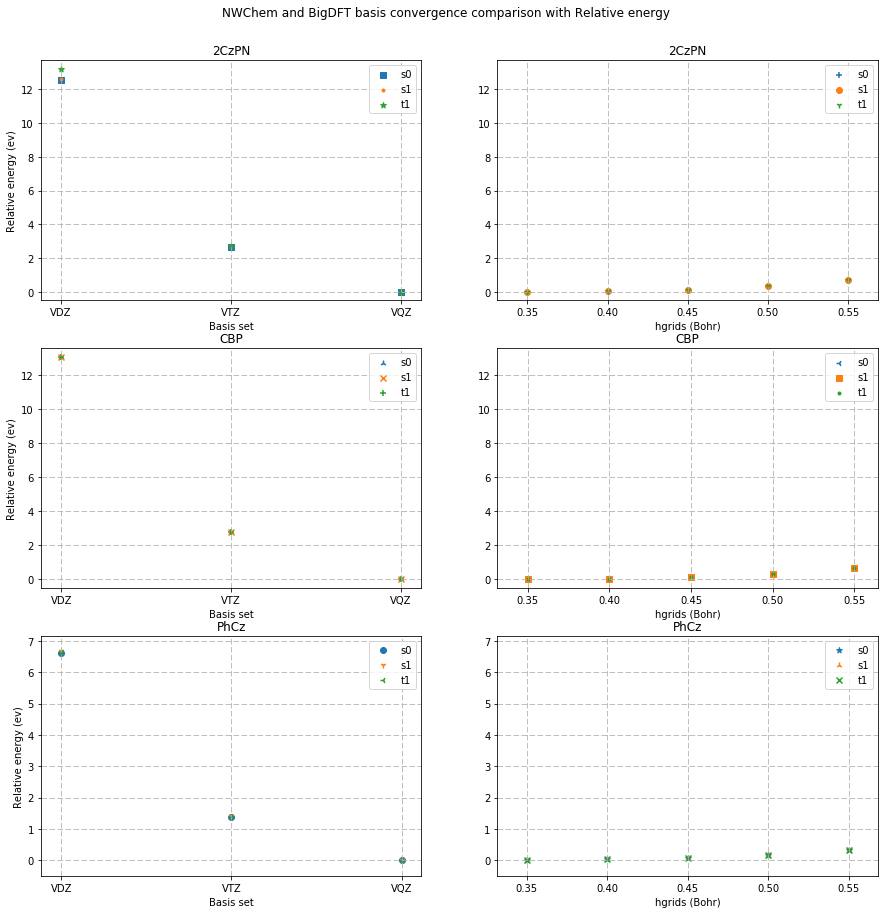

In [23]:
fig, axs = plt.subplots(3,2, figsize=(15,15))

i=0

for molecule in molecules:
    
    for state in states:
        nw_rel_es = []
        bd_rel_es = []        
        
        #NWChem
        for bas in code_to_bas['NWChem']:
            max_bas = code_to_bas['NWChem'][-1]
            
            nw_rel_e = data['NWChem'][molecule][bas][state]['total_energy'] - data['NWChem'][molecule][max_bas][state]['total_energy']
            
            nw_rel_es.append(nw_rel_e)
        
        axs[i,0].set_title(molecule)
        axs[i,0].scatter([1,2,3], nw_rel_es, label = state, marker = marker.next())
        
        axs[i,0].legend()
        axs[i,0].set_xticks([1, 2, 3])
        axs[i,0].set_xticklabels(['VDZ', 'VTZ', 'VQZ'])
        axs[i,0].set_xlabel("Basis set")
        axs[i,0].set_ylabel("Relative energy (ev)")


        #BigDFT
        for bas in code_to_bas['BigDFT']:
            for hgrid in hgrids:
                bd_rel_es.append(data['BigDFT'][molecule]['cubic'][hgrid][state]['total_energy'])

            rel_energies = [(e - bd_rel_es[0]) for e in bd_rel_es]
            
        axs[i,1].scatter(hgrids_float[1:], rel_energies[1:], label = state, marker = marker.next())
        axs[i,1].set_title(molecule)
        axs[i,1].legend()
        axs[i,1].set_xlabel("hgrids (Bohr)")
        
        #consistent y axis
        
        nw_max = max(nw_rel_es)
        bd_max = max(rel_energies[1:])
        
        ylim = max([nw_max, bd_max]) + 0.5
        xlim = 0 - 0.5
        
        axs[i,0].set_ylim([xlim,ylim])
        axs[i,1].set_ylim([xlim,ylim])
        
        axs[i,0].grid(linestyle='--')
        axs[i,1].grid(linestyle='--')
        

    i = 1 + i
        
fig.suptitle("NWChem and BigDFT basis convergence comparison with Relative energy", y=0.93) 

# #set common labels
# fig.text(0.1, 0.5, "Relative energy (eV)", va='center', rotation='vertical')
# fig.text(0.5, 0.04, "Basis set", ha = "center")

plt.show()

In [84]:
# for molecule in molecules:
#     for state in states:
#         energies = []

#         for hgrid in hgrids:
#             energies.append(data['BigDFT'][molecule]['cubic'][hgrid][state]['total_energy'])

#         rel_energies = [(e - energies[0]) for e in energies]

#         plt.title(molecule+" hgrids convergence. Relative energy to hgrid = 0.30")
#         plt.plot(hgrids_float[1:], rel_energies[1:], label = molecule+state)
#         plt.xticks(hgrids_float[1:], hgrids[1:])
#         plt.yscale("log")    

#         plt.legend()
#         plt.xlabel('hgrid (Bohr)')
#         plt.ylabel('Relative Energy (eV)')
        
#     plt.show()

# Absolute energy comparison

# $\Delta E_{ST}$

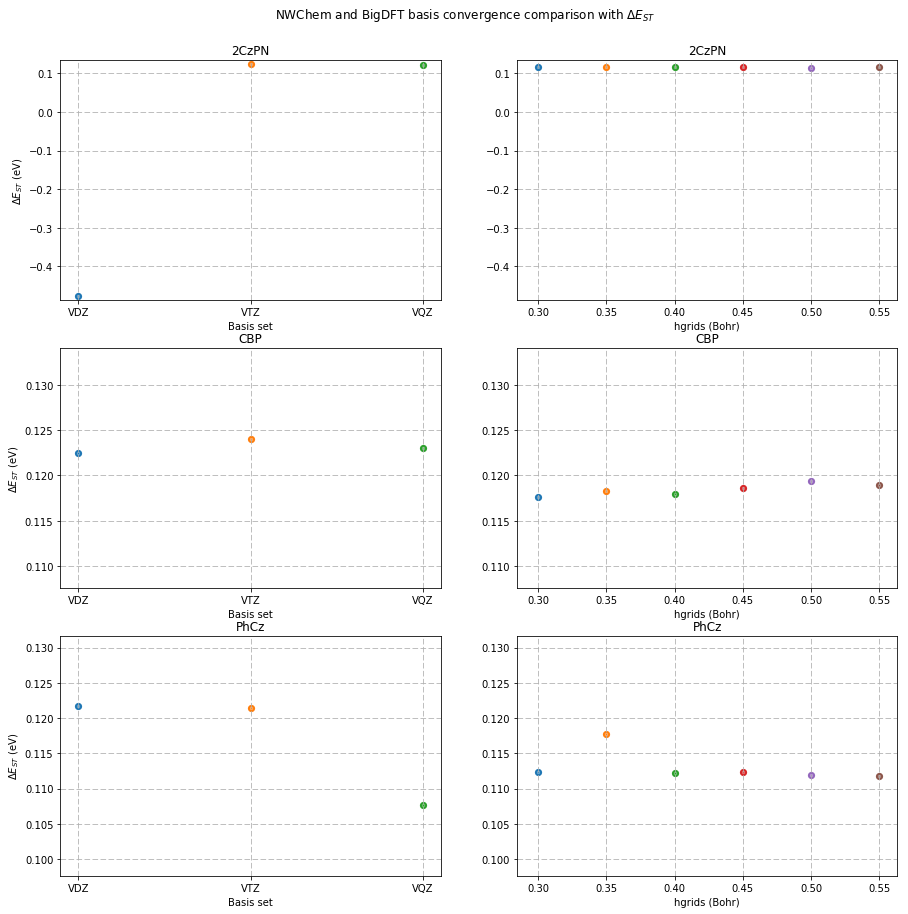

In [30]:
fig, axs = plt.subplots(3,2, figsize=(15,15))

i=0

for molecule in molecules:
    nw_dest = []
    bd_dest = []
    
#     nw_max = 0
#     bd_max = 0
    
#     nw_min = 0
#     bd_min = 0

    nw_j = 0
        
    for bas in code_to_bas['NWChem']:


        nw_s1 = data['NWChem'][molecule][bas]['s1']['total_energy'] - data['NWChem'][molecule][bas]['s0']['total_energy']
        nw_t1 = data['NWChem'][molecule][bas]['t1']['total_energy'] - data['NWChem'][molecule][bas]['s0']['total_energy']

        dest = nw_s1 - nw_t1
        nw_dest.append(dest)

        axs[i,0].scatter(nw_j, dest, marker = '.', s = 20, linewidth=5)

        nw_j = nw_j + 1
        
    for bas in code_to_bas['BigDFT']:
        
        for hgrid in hgrids:
        
            bd_s1 = data['BigDFT'][molecule][bas][hgrid]['s1']['total_energy'] - data['BigDFT'][molecule][bas][hgrid]['s0']['total_energy']
            bd_t1 = data['BigDFT'][molecule][bas][hgrid]['t1']['total_energy'] - data['BigDFT'][molecule][bas][hgrid]['s0']['total_energy']

            dest = bd_s1 - bd_t1
            bd_dest.append(dest)
            
            axs[i,1].scatter(hgrid, dest, marker = '.', s = 20, linewidth=5)

    axs[i,0].set_title(molecule)
    axs[i,0].set_xticks([0, 1, 2])
    axs[i,0].set_xticklabels(['VDZ', 'VTZ', 'VQZ']) 
    axs[i,0].set_xlabel("Basis set")
    axs[i,0].set_ylabel("$\Delta E_{ST}$ (eV)")
    
    axs[i,1].set_title(molecule)
    axs[i,1].legend()
    axs[i,1].set_xlabel("hgrids (Bohr)")

#     consistent y-axis
    
    nw_max = max(nw_dest)
    bd_max = max(bd_dest)
    
    nw_min = min(nw_dest)
    bd_min = min(bd_dest)

    ymaxlim = max([nw_max, bd_max]) + 0.01
    yminlim = min([nw_min, bd_min]) - 0.01

    axs[i,0].set_ylim([yminlim,ymaxlim])
    axs[i,1].set_ylim([yminlim,ymaxlim])
    
    axs[i,0].grid(linestyle='--')
    axs[i,1].grid(linestyle='--')
    
    i = 1 + i
        
fig.suptitle("NWChem and BigDFT basis convergence comparison with $\Delta E_{ST}$", y=0.93)    

#set common labels
# fig.text(0.05, 0.5, "$\Delta$ E$_{ST}$ energy (eV)", va='center', rotation='vertical')
# fig.text(0.5, 0.04, "Basis set", ha = "center")

plt.show()

# HOMO LUMO

In [22]:
marker = itertools.cycle((',', '+', '.',))
colour = itertools.cycle(('b','g','r','m'))

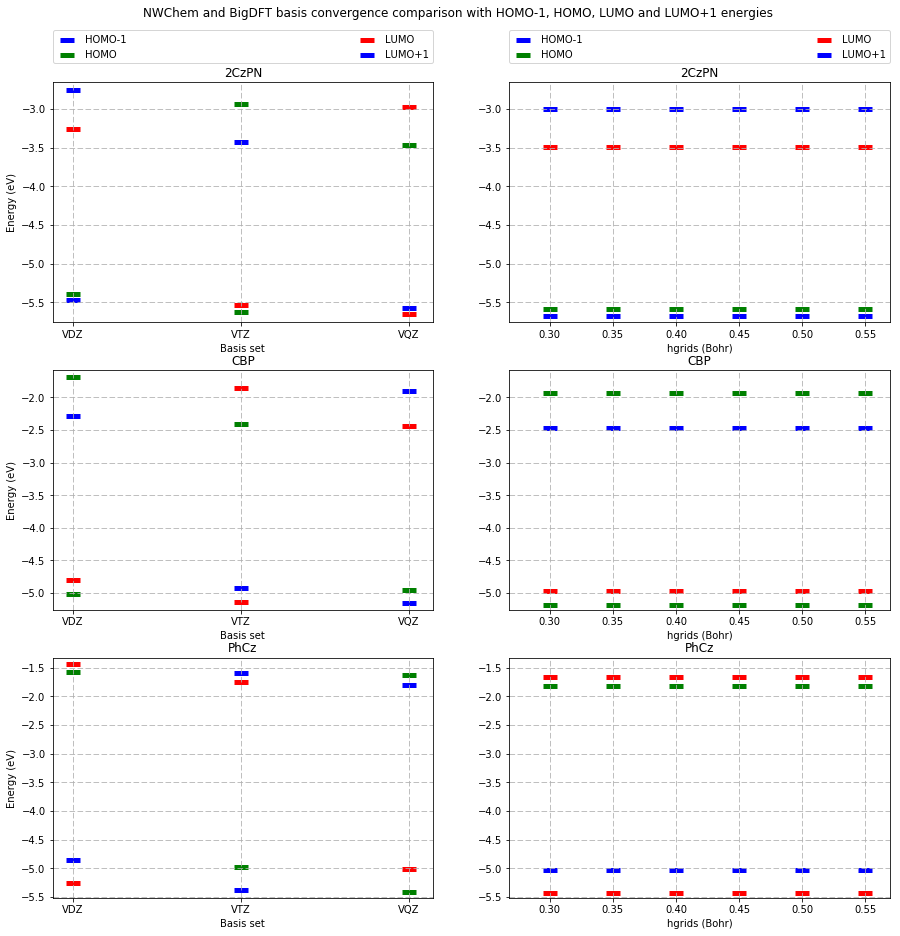

In [33]:
fig, axs = plt.subplots(3,2, figsize=(15,15))

i=0

for molecule in molecules:
    j = 0
    
    nw_HLs = []
    bd_HLs = []
    
    for bas in code_to_bas['NWChem']:
        for HL in HL_order:

            HL_e = data['NWChem'][molecule][bas][HL]
            nw_HLs.append(HL_e)
            
            #remove legend (as the marker is the same for different basis size)
            if i == 0 and j == 0:
                legend_label = HL
            else:
                legend_label = '_nolegend_'
            
            axs[i,0].scatter(j, HL_e, label = legend_label, marker = '_', s = 200, linewidth=5, color = colour.next())
            
            axs[i,0].legend()
            axs[0,0].legend(bbox_to_anchor=(0., 1.08, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

        j = j + 1
        
    for bas in code_to_bas['BigDFT']:
        for HL in HL_order:
            
            bd_color = colour.next()
            
            for hgrid in hgrids:
                
                HL_e = data['BigDFT'][molecule][bas][hgrid][HL] 
                bd_HLs.append(HL_e)
                
                #remove legend (as the marker is the same for different basis size)
                if i == 0 and hgrid == hgrids[0]:
                    legend_label = HL
                else:
                    legend_label = '_nolegend_'
                
                axs[i,1].scatter(hgrid, HL_e, label = legend_label, marker = '_', s = 200, linewidth=5, color = bd_color)
            
                axs[i,1].legend()
                axs[0,1].legend(bbox_to_anchor=(0., 1.08, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
            
    
    axs[i,0].set_title(molecule)
    axs[i,0].set_xticks([0, 1, 2])
    axs[i,0].set_xticklabels(['VDZ', 'VTZ', 'VQZ'])
    axs[i,0].set_xlabel("Basis set")
    axs[i,0].set_ylabel("Energy (eV)")
    
    axs[i,1].set_title(molecule)
#     axs[i,1].legend()
    axs[i,1].set_xlabel("hgrids (Bohr)")
    
#     consistent y-axis
    
    nw_max = max(nw_HLs)
    bd_max = max(bd_HLs)
    
    nw_min = min(nw_HLs)
    bd_min = min(nw_HLs)

    ymaxlim = max([nw_max, bd_max]) + 0.1
    yminlim = min([nw_min, bd_min]) - 0.1

    axs[i,0].set_ylim([yminlim,ymaxlim])
    axs[i,1].set_ylim([yminlim,ymaxlim])
    
    axs[i,0].grid(linestyle='--')
    axs[i,1].grid(linestyle='--')
    
    i = 1 + i
    
    
fig.suptitle("NWChem and BigDFT basis convergence comparison with HOMO-1, HOMO, LUMO and LUMO+1 energies", y=0.95)    

#set common labels
# fig.text(0.08, 0.5, "HOMO LUMO Energy (eV)", va='center', rotation='vertical')
# fig.text(0.5, 0.04, "Basis set", ha = "center")

plt.show()

# CPU TIME Comparison

In [24]:
colour = itertools.cycle(('b','g','r'))

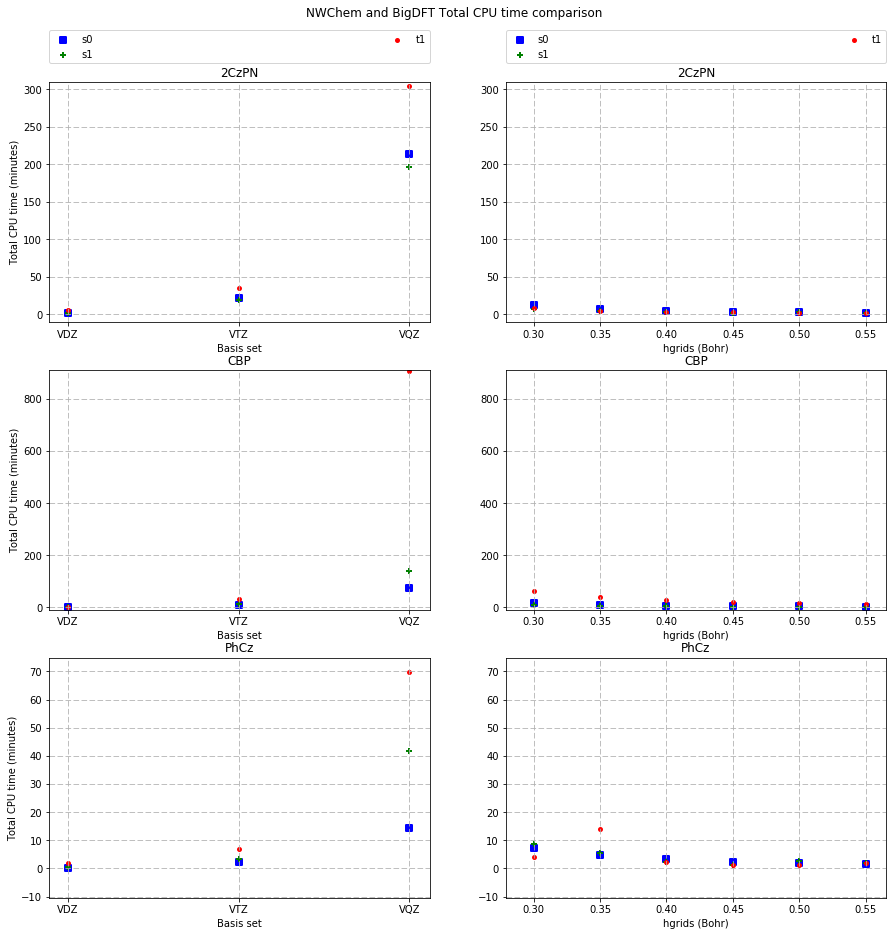

In [31]:
fig, axs = plt.subplots(3,2, figsize=(15,15))

i=0

for molecule in molecules:
    j = 0
    
    nw_cput = []
    bd_cput = []    
    
    for bas in code_to_bas['NWChem']:
        for state in states:

            cput = data['NWChem'][molecule][bas][state]['CPU_time'] / 60
            
            nw_cput.append(cput)
            
            #remove legend (as the marker is the same for different basis size)
            if i == 0 and j == 0:
                legend_label = state
            else:
                legend_label = '_nolegend_'
            
            axs[i,0].scatter(j, cput, label = legend_label, marker = marker.next(), linewidth=2, color = colour.next())
            
        axs[0,0].legend(bbox_to_anchor=(0., 1.08, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

        j = j + 1
        
    for bas in code_to_bas['BigDFT']:
        for state in states:
            
            bd_marker = marker.next()
            bd_color = colour.next()
            
            for hgrid in hgrids:
                
                cput = data['BigDFT'][molecule]['cubic'][hgrid][state]['CPU_time'] / 60
                
                bd_cput.append(cput)
                
                #remove legend (as the marker is the same for different basis size)
                if i == 0 and hgrid == hgrids[0]:
                    legend_label = state
                else:
                    legend_label = '_nolegend_'
                
                axs[i,1].scatter(hgrid, cput, label = legend_label, marker = bd_marker, linewidth=2, color = bd_color)
            
                axs[0,1].legend(bbox_to_anchor=(0., 1.08, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
            
    
    axs[i,0].set_title(molecule)
    axs[i,0].set_xticks([0, 1, 2])
    axs[i,0].set_xticklabels(['VDZ', 'VTZ', 'VQZ'])
    axs[i,0].set_xlabel("Basis set")
    axs[i,0].set_ylabel("Total CPU time (minutes)")
    
    axs[i,1].set_title(molecule)
#     axs[i,1].legend()
    axs[i,1].set_xlabel("hgrids (Bohr)")
    
#     consistent y-axis
    
    nw_max = max(nw_cput)
    bd_max = max(bd_cput)
    
    nw_min = min(nw_HLs)
    bd_min = min(nw_HLs)

    ymaxlim = max([nw_max, bd_max]) + 5
    yminlim = min([nw_min, bd_min]) - 5

    axs[i,0].set_ylim([yminlim,ymaxlim])
    axs[i,1].set_ylim([yminlim,ymaxlim])
    
    axs[i,0].grid(linestyle='--')
    axs[i,1].grid(linestyle='--')
    
    i = 1 + i
    
    
fig.suptitle("NWChem and BigDFT Total CPU time comparison", y=0.95)    

#set common labels
# fig.text(0.08, 0.5, "HOMO LUMO Energy (eV)", va='center', rotation='vertical')
# fig.text(0.5, 0.04, "Basis set", ha = "center")

plt.show()

In [26]:
# for molecule in molecules:
#     for state in states:
#         cput = []

#         for hgrid in hgrids:
#             cput.append(data['BigDFT'][molecule]['cubic'][hgrid][state]['CPU_time'])

#         plt.title(molecule+" hgrid CPU timings")
#         plt.plot(hgrids_float, cput, label = molecule+state)
#         plt.xticks(hgrids_float, hgrids) 

#         plt.legend()
#         plt.xlabel('hgrid (Bohr)')
#         plt.ylabel('CPU time (s)')
        
#     plt.show()

NOTE: add iterations on the graph next to the CPU time

### Forces

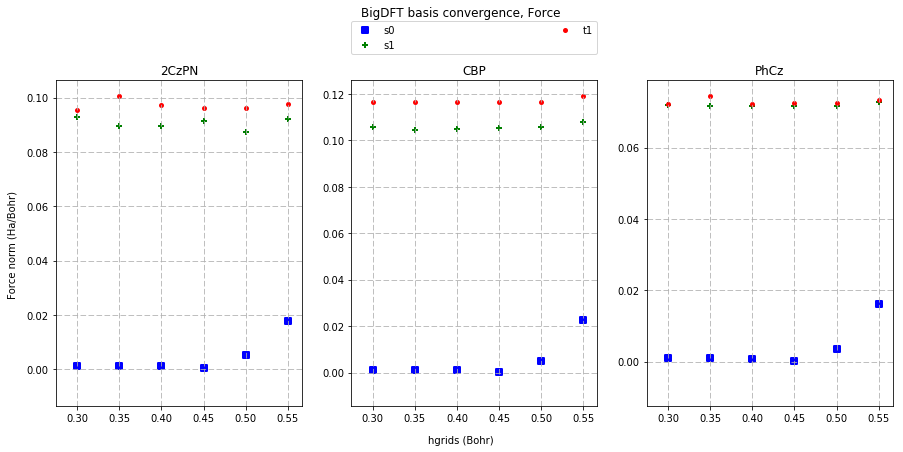

In [27]:
# log.log['Atomic Forces (Ha/Bohr)']

fig, axs = plt.subplots(1,3, figsize=(15,6))

i=0

for molecule in molecules:
    dests = []

    j = 0
        
    for bas in code_to_bas['BigDFT']:
        
        for state in states:
            
            bd_marker = marker.next()
            bd_color = colour.next()
            
            for hgrid in hgrids:

                force = data['BigDFT'][molecule][bas][hgrid][state]['forces']

                #remove legend (as the marker is the same for different basis size)
                if i == 1 and hgrid == hgrids[0]:
                    legend_label = state
                else:
                    legend_label = '_nolegend_'

                axs[i].scatter(hgrid, force, label = legend_label, marker = bd_marker, linewidth=2, color = bd_color)
                
                axs[1].legend(bbox_to_anchor=(0., 1.08, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
                axs[1].legend(bbox_to_anchor=(0., 1.08, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)

                j = j + 1



    axs[i].set_title(molecule)
    axs[i].grid(linestyle='--')
    axs[i].grid(linestyle='--')


    i = 1 + i
        
fig.suptitle("BigDFT hgrid convergence with Force", y = 1.05 )    

#set common labels
fig.text(0.08, 0.5, "Force norm (Ha/Bohr)", va='center', rotation='vertical')
fig.text(0.5, 0.04, "hgrids (Bohr)", ha = "center")

plt.show()